In [115]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Density = pd.read_csv('~/Documents/NYCDSA/Capstone/Density_Atlanta/Density_Atlanta.csv')
Atlanta_Density['Total Bathrooms'] = Atlanta_Density['number_of_full_baths'] + (Atlanta_Density['number_of_half_baths']*0.5)
Atlanta_Density = Atlanta_Density.drop(columns=['latitude',
                                                  'longitude', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address'])
Atlanta_Density = Atlanta_Density.rename(columns={'SM_One': 'Supermarket (One Mile)', 'C_One': 'Convenience (One Mile)',
'WS_One': 'Wholesale (One Mile)', 'VS_One': 'Variety Store (One Mile)', 'SC_One': 'Supercenter (One Mile)', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories',
                                                   'SM_Five': 'Supermarket (Five Miles)', 'C_Five': 'Convenience (Five Miles)', 'year_built': 'Year Built',
'WS_Five': 'Wholesale (Five Miles)', 'VS_Five': 'Variety Store (Five Miles)', 'SC_Five': 'Supercenter (Five Miles)',
                                                 'WS_Three': 'Wholesale (Three Miles)', 'VS_Three': 'Variety Store (Three Miles)',
                                                  'SM_Three': 'Supermarket (Three Miles)', 'SC_Three': 'Supercenter (Three Miles)', 'C_Three': 'Convenience (Three Miles)'})
Atlanta_Density['Year Built'] = Atlanta_Density['Year Built'].astype('Int64') #For numerical analysis: Use int or float if there are missing values
Atlanta_Density_One = Atlanta_Density.drop(columns=['Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)',
                                                   'Wholesale (Three Miles)','Variety Store (Three Miles)','Supermarket (Three Miles)', 'Supercenter (Three Miles)','Convenience (Three Miles)'])
Atlanta_Density_One

,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,2865,2002,4,3259.0,0,0,0,0,0,2.5
1,2200,<NA>,3,1993.0,2,1,0,2,0,2.0
2,2000,<NA>,3,1910.0,0,0,0,0,0,2.0
3,1995,<NA>,3,1134.0,0,0,0,0,0,1.0
4,2800,<NA>,4,2532.0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...
21010,1600,<NA>,3,1367.0,0,0,0,0,0,2.0
21011,2199,<NA>,3,1696.0,1,0,1,0,0,2.5
21012,2380,2015,3,1944.0,0,1,1,1,1,3.5
21013,1900,<NA>,4,1204.0,1,0,0,1,0,2.0


In [116]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Density_One.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [117]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Density_One)

In [118]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

In [119]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,0.177326
1,-1.091762e-14,-0.459475,0.111774,1.973794,3.756991,-0.527769,2.856081,-0.093726,-0.475680
2,-1.091762e-14,-0.459475,0.032935,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,0.798544,-0.229536,0.857576,-0.411410,-0.093726,0.177326
21012,1.127320e+00,-0.459475,0.065230,-0.376706,3.756991,0.857576,1.222336,10.669399,1.483337
21013,-1.091762e-14,0.641662,-0.637674,0.798544,-0.229536,-0.527769,1.222336,-0.093726,-0.475680


In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
model = LinearRegression()

# Target variable
y = Atlanta_Density_One['current_listing_price']
# All features
X = Atlanta_Density_One.drop(columns='current_listing_price')
model = LinearRegression()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

y_train_log = np.log1p(y_train)  
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)
y_combined_log = np.log1p(y_train_val)

# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model),
])
# Initialize the linear regression model
# Fit the model on the training data
pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (One Mile)', 'Supercenter (One Mile)',
       'Supermarket (One Mile)', 'Variety Store (One Mile)',
       'Wholesale (One Mile)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [121]:
val_score = pipeline.score(X_val, y_val_log) #0.6137914878103629
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test_log) #0.55202185736604
print('Test R^2:', test_score)

combined_score = pipeline.score(X_train_val, y_combined_log)
print('Combined R^2:', combined_score)

Validation R^2: 0.3969882772304918
Test R^2: 0.31740817092854856
Combined R^2: 0.39278703280343485


In [122]:
from sklearn.metrics import mean_squared_error 
y_val_pred = pipeline.predict(X_val)

val_mse = mean_squared_error(y_val_log, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test_log, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

y_combined_pred = pipeline.predict(X_train_val)

combined_mse = mean_squared_error(y_combined_log, y_combined_pred)
print('Combined Mean Squared Error:', combined_mse)
combined_rmse = np.sqrt(combined_mse)
print("Combined Root Mean Squared Error:", combined_rmse)

Validation Mean Squared Error: 0.06592076402292156
Validation Root Mean Squared Error: 0.25675039244940123
Test Mean Squared Error: 0.07683259614269028
Test Root Mean Squared Error: 0.2771869335713541
Combined Mean Squared Error: 0.06625476570523238
Combined Root Mean Squared Error: 0.2574000110824247


In [123]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val_log, y_val_pred)
test_mape = calculate_mape(y_test_log, y_test_pred)
combined_mape = calculate_mape(y_combined_log, y_combined_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape)
print("Combined Mean Absolute Percentage Error (MAPE):", combined_mape)

Validation Mean Absolute Percentage Error (MAPE): 2.2723846857408057
Test Mean Absolute Percentage Error (MAPE): 2.326816471699822
Combined Mean Absolute Percentage Error (MAPE): 2.301276209958667


In [128]:
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

# Display the coefficients
print("Coefficients One Mile (MLE):", coefficients)
print("Intercept (MLE):", intercept)

Coefficients One Mile (MLE): [ 0.00194896  0.06185909  0.07552861  0.04326296 -0.001067    0.04481717
 -0.0123856   0.0067574   0.10354858]
Intercept (MLE): 7.669291945520549


In [129]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient One Mile (MLE)': coefficients
})
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient One Mile (MLE)': [intercept]})
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

coef_df['Absolute Coefficient'] = coef_df['Coefficient One Mile (MLE)']  # Create a new column for absolute values
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df)

                    Feature  Coefficient One Mile (MLE)
9                 Intercept                    7.669292
8           Total Bathrooms                    0.103549
2          Living Area(SQF)                    0.075529
1            Total Bedrooms                    0.061859
5    Supermarket (One Mile)                    0.044817
3    Convenience (One Mile)                    0.043263
7      Wholesale (One Mile)                    0.006757
0                Year Built                    0.001949
4    Supercenter (One Mile)                   -0.001067
6  Variety Store (One Mile)                   -0.012386


In [130]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=42)
param = {
    'regressor__alpha': [100]
}
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_model),
])
ridge_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
ridge_search.fit(X_train, y_train_log)
ridge_pipeline.fit(X_train, y_train_log)
print("Best parameters:", ridge_search.best_params_)
print("Best R^2:", ridge_search.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100}
Best R^2: 0.3874784460318387


In [131]:
best_model = ridge_search.best_estimator_
results = ridge_search.cv_results_
mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Mean MSE scores: [0.06670415]
Mean MAPE scores: [0.02314078]
Mean R^2 scores: [0.38747845]
Mean RMSE scores: [0.2581077]


In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mse, mape, rmse

In [133]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val_log, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test_log, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_combined_log, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.3969
MSE: 0.0659
MAPE: 0.0227
RMSE: 0.2568

Tuned Test Set Scores:
R²: 0.3178
MSE: 0.0768
MAPE: 0.0233
RMSE: 0.2771

Tuned Train-Val Set Scores:
R²: 0.3927
MSE: 0.0663
MAPE: 0.0230
RMSE: 0.2574


In [71]:
coefficients = ridge_pipeline.named_steps['regressor'].coef_
intercept = ridge_pipeline.named_steps['regressor'].intercept_

In [134]:
coef_df_ridge = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient One Mile (MLE)': coefficients
})

#Add intercept row
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient One Mile (MLE)': [intercept]})
coef_df_ridge = pd.concat([coef_df_ridge, intercept_row], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge['Absolute Coefficient'] = coef_df_ridge['Coefficient One Mile (MLE)']  # Create a new column for absolute values
coef_df_ridge = coef_df_ridge.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge)

                    Feature  Coefficient One Mile (MLE)
9                 Intercept                    7.669292
8           Total Bathrooms                    0.103549
2          Living Area(SQF)                    0.075529
1            Total Bedrooms                    0.061859
5    Supermarket (One Mile)                    0.044817
3    Convenience (One Mile)                    0.043263
7      Wholesale (One Mile)                    0.006757
0                Year Built                    0.001949
4    Supercenter (One Mile)                   -0.001067
6  Variety Store (One Mile)                   -0.012386


In [73]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=42)
param_lasso = {
    'regressor__alpha': [1.0]
}
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso_model),
])
lasso_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_lasso,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)
lasso_search.fit(X_train, y_train_log)
lasso_pipeline.fit(X_train, y_train_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (One Mile)', 'Supercenter (One Mile)',
       'Supermarket (One Mile)', 'Variety Store (One Mile)',
       'Wholesale (One Mile)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Lasso(random_state=42))])

In [74]:
print("Best parameters:", lasso_search.best_params_)
print("Best R^2:", lasso_search.best_score_)

Best parameters: {'regressor__alpha': 1.0}
Best R^2: -0.0004325497656059385


In [75]:
best_model_lasso = lasso_search.best_estimator_
results_lasso = lasso_search.cv_results_

y_val_pred_tuned_lasso = best_model_lasso.predict(X_val)
val_scores_lasso = calculate_scores(y_val_log, y_val_pred_tuned_lasso)

y_test_pred_tuned_lasso = best_model_lasso.predict(X_test)
test_scores_lasso = calculate_scores(y_test_log, y_test_pred_tuned_lasso)

y_combined_pred_tuned_lasso = best_model_lasso.predict(X_train_val)
combined_scores_lasso = calculate_scores(y_combined_log, y_combined_pred_tuned_lasso)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_lasso[0]:.4f}")
print(f"MSE: {val_scores_lasso[1]:.4f}")
print(f"MAPE: {val_scores_lasso[2]:.4f}")
print(f"RMSE: {val_scores_lasso[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_lasso[0]:.4f}")
print(f"MSE: {test_scores_lasso[1]:.4f}")
print(f"MAPE: {test_scores_lasso[2]:.4f}")
print(f"RMSE: {test_scores_lasso[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso[0]:.4f}")
print(f"MSE: {combined_scores_lasso[1]:.4f}")
print(f"MAPE: {combined_scores_lasso[2]:.4f}")
print(f"RMSE: {combined_scores_lasso[3]:.4f}")

Tuned Validation Set Scores:
R²: -0.0000
MSE: 0.1093
MAPE: 0.0310
RMSE: 0.3306

Tuned Test Set Scores:
R²: -0.0001
MSE: 0.1126
MAPE: 0.0313
RMSE: 0.3355

Tuned Train-Val Set Scores:
R²: -0.0000
MSE: 0.1091
MAPE: 0.0309
RMSE: 0.3303


In [76]:
coefficients = lasso_pipeline.named_steps['regressor'].coef_
intercept = lasso_pipeline.named_steps['regressor'].intercept_

In [77]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

coef_df['Absolute Coefficient'] = coef_df['Coefficient (MLE)']  # Create a new column for absolute values
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df)

                    Feature  Coefficient (MLE)
9                 Intercept           7.669292
0                Year Built           0.000000
1            Total Bedrooms           0.000000
2          Living Area(SQF)           0.000000
3    Convenience (One Mile)           0.000000
4    Supercenter (One Mile)           0.000000
5    Supermarket (One Mile)           0.000000
6  Variety Store (One Mile)          -0.000000
7      Wholesale (One Mile)           0.000000
8           Total Bathrooms           0.000000


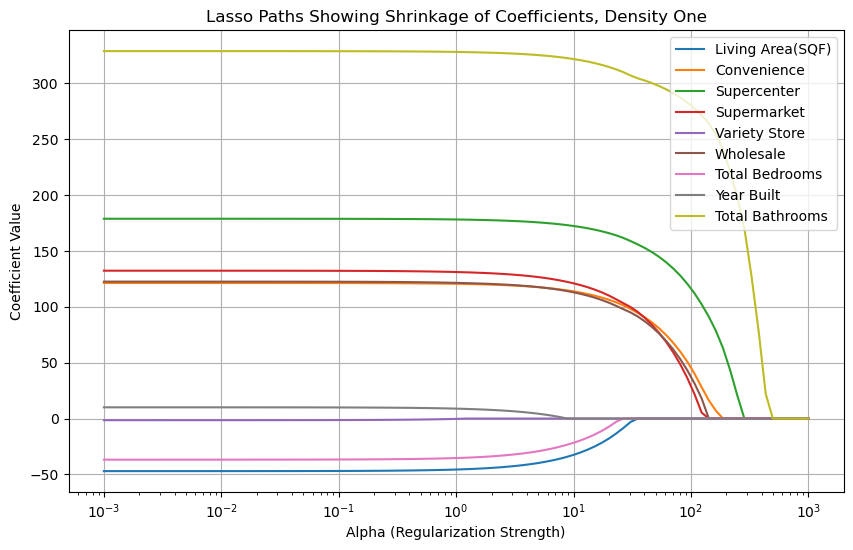

In [114]:
# Define the range of alpha values (regularization strength)
alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()
X_scaled = transformed_df

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)', 'Convenience', 'Supercenter', 'Supermarket', 'Variety Store', 'Wholesale', 'Total Bedrooms', 'Year Built', 'Total Bathrooms']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients, Density One")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
plt.show()

In [135]:
Atlanta_Density_Three = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                      'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)'])
numeric_features_three = Atlanta_Density_Three.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_three = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_three = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_three, numeric_features_three),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_three = preprocessor_three.fit_transform(Atlanta_Density_Three)

In [136]:
# Combine all feature names
all_feature_names_three = list(numeric_features_three)
transformed_df_three = pd.DataFrame(transformed_data_three, columns=all_feature_names_three)

In [137]:
# Assuming RandomForest is part of your models dictionary
model = LinearRegression()
# Define the full model pipeline including the preprocessor
pipeline_three = Pipeline([
    ('preprocessor', preprocessor_three),
    ('regressor', model)
])
X_three = Atlanta_Density_Three.drop(columns='current_listing_price')
y_three = Atlanta_Density_Three['current_listing_price']

X_train_val_three, X_test_three, y_train_val_three, y_test_three = train_test_split(X_three, y_three, test_size=0.2, random_state=42)
X_train_three, X_val_three, y_train_three, y_val_three = train_test_split(X_train_val_three, y_train_val_three, test_size=0.25, random_state=42)

y_train_three_log = np.log1p(y_train_three)  
y_val_three_log = np.log1p(y_val_three)
y_test_three_log = np.log1p(y_test_three)
y_combined_three_log = np.log1p(y_train_val_three)

# Fit the model pipeline
pipeline_three.fit(X_train_three, y_train_three_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Wholesale (Three Miles)', 'Variety Store (Three Miles)',
       'Supermarket (Three Miles)', 'Supercenter (Three Miles)',
       'Convenience (Three Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [138]:
val_score_three = pipeline_three.score(X_val_three, y_val_three_log)
print('Validation R^2:', val_score_three)

test_score_three = pipeline_three.score(X_test_three, y_test_three_log)
print('Test R^2:', test_score_three)

combined_score_three = pipeline_three.score(X_train_val_three, y_combined_three_log)
print('Combined R^2:', combined_score_three)

Validation R^2: 0.45906602547829933
Test R^2: 0.38644506923696054
Combined R^2: 0.45463827854787864


In [139]:
y_val_pred_three = pipeline_three.predict(X_val_three)

val_mse_three = mean_squared_error(y_val_three_log, y_val_pred_three)
print('Validation Mean Squared Error:', val_mse_three)
val_rmse_three = np.sqrt(val_mse_three)
print("Validation Root Mean Squared Error:", val_rmse_three)

y_test_pred_three = pipeline_three.predict(X_test_three)

test_mse_three = mean_squared_error(y_test_three_log, y_test_pred_three)
print('Test Mean Squared Error:', test_mse_three)
test_rmse_three = np.sqrt(test_mse_three)
print("Test Root Mean Squared Error:", test_rmse_three)

y_combined_pred_three = pipeline_three.predict(X_train_val_three)

combined_mse_three = mean_squared_error(y_combined_three_log, y_combined_pred_three)
print('Combined Mean Squared Error:', combined_mse_three)
combined_rmse_three = np.sqrt(combined_mse_three)
print("Combined Root Mean Squared Error:", combined_rmse_three)

Validation Mean Squared Error: 0.05913447374232242
Validation Root Mean Squared Error: 0.24317580829992613
Test Mean Squared Error: 0.06906179681465004
Test Root Mean Squared Error: 0.2627961126323029
Combined Mean Squared Error: 0.05950599712360178
Combined Root Mean Squared Error: 0.24393851094815222


In [140]:
val_mape_three = calculate_mape(y_val_three_log, y_val_pred_three)
test_mape_three = calculate_mape(y_test_three_log, y_test_pred_three)
combined_mape_three = calculate_mape(y_combined_three_log, y_combined_pred_three)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape_three)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape_three) #A lower MAPE value indicates a more accurate prediction
print("Combined Mean Absolute Percentage Error (MAPE):", combined_mape_three)

Validation Mean Absolute Percentage Error (MAPE): 2.1583435231083117
Test Mean Absolute Percentage Error (MAPE): 2.195735570410678
Combined Mean Absolute Percentage Error (MAPE): 2.183483358002871


In [141]:
coefficients_three = pipeline_three.named_steps['regressor'].coef_
intercept_three = pipeline_three.named_steps['regressor'].intercept_

# Display the coefficients
print("Coefficients Three Miles (MLE):", coefficients_three)
print("Intercept (MLE):", intercept_three)

Coefficients Three Miles (MLE): [ 0.0174367   0.07479926  0.07188502 -0.00390637 -0.03065584  0.07438978
  0.01543551  0.05966772  0.09043951]
Intercept (MLE): 7.669291945520549


In [142]:
coef_df_three = pd.DataFrame({
    'Feature': all_feature_names_three,
    'Coefficient Three Miles (MLE)': coefficients_three
})
intercept_row_three = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient Three Miles (MLE)': [intercept_three]})
coef_df_three = pd.concat([coef_df_three, intercept_row_three], ignore_index=True)

coef_df_three['Absolute Coefficient'] = coef_df_three['Coefficient Three Miles (MLE)']  # Create a new column for absolute values
coef_df_three = coef_df_three.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_three)

                       Feature  Coefficient Three Miles (MLE)
9                    Intercept                       7.669292
8              Total Bathrooms                       0.090440
1               Total Bedrooms                       0.074799
5    Supermarket (Three Miles)                       0.074390
2             Living Area(SQF)                       0.071885
7    Convenience (Three Miles)                       0.059668
0                   Year Built                       0.017437
6    Supercenter (Three Miles)                       0.015436
3      Wholesale (Three Miles)                      -0.003906
4  Variety Store (Three Miles)                      -0.030656


In [143]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=42)
param_three = {
    'regressor__alpha': [100]
}
ridge_pipeline_three = Pipeline(steps=[
    ('preprocessor', preprocessor_three),
    ('regressor', ridge_model),
])
ridge_search_three = GridSearchCV(
    estimator=ridge_pipeline_three,
    param_grid=param_three,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
ridge_search_three.fit(X_train_three, y_train_three_log)
ridge_pipeline_three.fit(X_train_three, y_train_three_log)
print("Best parameters:", ridge_search_three.best_params_)
print("Best R^2:", ridge_search_three.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100}
Best R^2: 0.4495105466845917


In [144]:
best_model_ridge_three = ridge_search_three.best_estimator_
results_ridge_three = ridge_search_three.cv_results_
y_val_pred_tuned_ridge_three = best_model_ridge_three.predict(X_val_three)
val_scores_ridge_three = calculate_scores(y_val_three_log, y_val_pred_tuned_ridge_three)

y_test_pred_tuned_ridge_three = best_model_ridge_three.predict(X_test_three)
test_scores_ridge_three = calculate_scores(y_test_three_log, y_test_pred_tuned_ridge_three)

y_combined_pred_tuned_ridge_three = best_model_ridge_three.predict(X_train_val_three)
combined_scores_ridge_three = calculate_scores(y_combined_three_log, y_combined_pred_tuned_ridge_three)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_ridge_three[0]:.4f}")
print(f"MSE: {val_scores_ridge_three[1]:.4f}")
print(f"MAPE: {val_scores_ridge_three[2]:.4f}")
print(f"RMSE: {val_scores_ridge_three[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_ridge_three[0]:.4f}")
print(f"MSE: {test_scores_ridge_three[1]:.4f}")
print(f"MAPE: {test_scores_ridge_three[2]:.4f}")
print(f"RMSE: {test_scores_ridge_three[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_ridge_three[0]:.4f}")
print(f"MSE: {combined_scores_ridge_three[1]:.4f}")
print(f"MAPE: {combined_scores_ridge_three[2]:.4f}")
print(f"RMSE: {combined_scores_ridge_three[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4589
MSE: 0.0592
MAPE: 0.0216
RMSE: 0.2432

Tuned Test Set Scores:
R²: 0.3866
MSE: 0.0690
MAPE: 0.0220
RMSE: 0.2628

Tuned Train-Val Set Scores:
R²: 0.4546
MSE: 0.0595
MAPE: 0.0218
RMSE: 0.2439


In [145]:
coefficients_three = ridge_pipeline_three.named_steps['regressor'].coef_
intercept_three = ridge_pipeline_three.named_steps['regressor'].intercept_

In [146]:
coef_df_ridge_three = pd.DataFrame({
    'Feature': all_feature_names_three,
    'Coefficient Three Miles (MLE)': coefficients_three
})

# Add intercept row
intercept_row_three = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient Three Miles (MLE)': [intercept]})
coef_df_ridge_three = pd.concat([coef_df_ridge_three, intercept_row_three], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge_three['Absolute Coefficient'] = coef_df_ridge_three['Coefficient Three Miles (MLE)']  # Create a new column for absolute values
coef_df_ridge_three = coef_df_ridge_three.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge_three)

                       Feature  Coefficient Three Miles (MLE)
9                    Intercept                       7.669292
8              Total Bathrooms                       0.090436
1               Total Bedrooms                       0.074796
5    Supermarket (Three Miles)                       0.074385
2             Living Area(SQF)                       0.071883
7    Convenience (Three Miles)                       0.059661
0                   Year Built                       0.017436
6    Supercenter (Three Miles)                       0.015436
3      Wholesale (Three Miles)                      -0.003906
4  Variety Store (Three Miles)                      -0.030651


In [91]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=42)
param_lasso = {
    'regressor__alpha': [1.0]
}
lasso_pipeline_three = Pipeline(steps=[
    ('preprocessor', preprocessor_three),
    ('regressor', lasso_model),
])
lasso_search_three = GridSearchCV(
    estimator=lasso_pipeline_three,
    param_grid=param_lasso,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)
lasso_search_three.fit(X_train_three, y_train_three_log)
lasso_pipeline_three.fit(X_train_three, y_train_three_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Wholesale (Three Miles)', 'Variety Store (Three Miles)',
       'Supermarket (Three Miles)', 'Supercenter (Three Miles)',
       'Convenience (Three Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Lasso(random_state=42))])

In [92]:
print("Best parameters:", lasso_search_three.best_params_)
print("Best R^2:", lasso_search_three.best_score_)

Best parameters: {'regressor__alpha': 1.0}
Best R^2: -0.0004325497656059385


In [93]:
best_model_lasso_three = lasso_search_three.best_estimator_
results_lasso_three = lasso_search_three.cv_results_

y_val_pred_tuned_lasso_three = best_model_lasso_three.predict(X_val_three)
val_scores_lasso_three = calculate_scores(y_val_three_log, y_val_pred_tuned_lasso_three)

y_test_pred_tuned_lasso_three = best_model_lasso_three.predict(X_test_three)
test_scores_lasso_three = calculate_scores(y_test_three_log, y_test_pred_tuned_lasso_three)

y_combined_pred_tuned_lasso_three = best_model_lasso_three.predict(X_train_val_three)
combined_scores_lasso_three = calculate_scores(y_combined_three_log, y_combined_pred_tuned_lasso_three)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_lasso_three[0]:.4f}")
print(f"MSE: {val_scores_lasso_three[1]:.4f}")
print(f"MAPE: {val_scores_lasso_three[2]:.4f}")
print(f"RMSE: {val_scores_lasso_three[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_lasso_three[0]:.4f}")
print(f"MSE: {test_scores_lasso_three[1]:.4f}")
print(f"MAPE: {test_scores_lasso_three[2]:.4f}")
print(f"RMSE: {test_scores_lasso_three[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso_three[0]:.4f}")
print(f"MSE: {combined_scores_lasso_three[1]:.4f}")
print(f"MAPE: {combined_scores_lasso_three[2]:.4f}")
print(f"RMSE: {combined_scores_lasso_three[3]:.4f}")

Tuned Validation Set Scores:
R²: -0.0000
MSE: 0.1093
MAPE: 0.0310
RMSE: 0.3306

Tuned Test Set Scores:
R²: -0.0001
MSE: 0.1126
MAPE: 0.0313
RMSE: 0.3355

Tuned Train-Val Set Scores:
R²: -0.0000
MSE: 0.1091
MAPE: 0.0309
RMSE: 0.3303


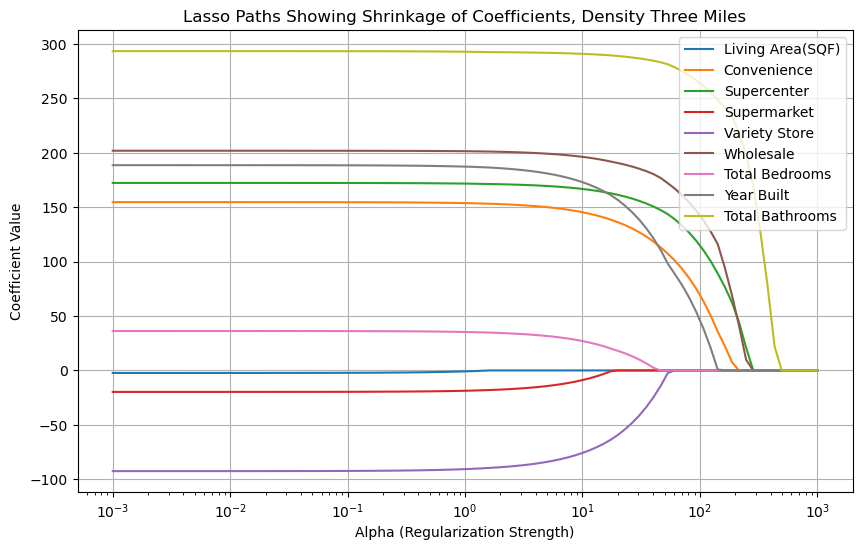

In [94]:
# Define the range of alpha values (regularization strength)
alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(transformed_df_three, y_three)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)', 'Convenience', 'Supercenter', 'Supermarket', 'Variety Store', 'Wholesale', 'Total Bedrooms', 'Year Built', 'Total Bathrooms']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients, Density Three Miles")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
plt.show()

In [147]:
Atlanta_Density_Five = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                    'Wholesale (Three Miles)', 'Variety Store (Three Miles)','Supermarket (Three Miles)','Supercenter (Three Miles)', 'Convenience (Three Miles)'])
numeric_features_five = Atlanta_Density_Five.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_five = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_five = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_five, numeric_features_five),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_five = preprocessor_five.fit_transform(Atlanta_Density_Five)

In [148]:
# Combine all feature names
all_feature_names_five = list(numeric_features_five)
transformed_df_five = pd.DataFrame(transformed_data_five, columns=all_feature_names_five)

In [149]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y_five = Atlanta_Density_Five['current_listing_price']
# All features
X_five = Atlanta_Density_Five.drop(columns='current_listing_price')

pipeline_five = Pipeline([
    ('preprocessor', preprocessor_five),
    ('regressor', model)
])

X_train_val_five, X_test_five, y_train_val_five, y_test_five = train_test_split(X_five, y_five, test_size=0.2, random_state=42)
X_train_five, X_val_five, y_train_five, y_val_five = train_test_split(X_train_val_five, y_train_val_five, test_size=0.25, random_state=42)

y_train_five_log = np.log1p(y_train_five)  
y_val_five_log = np.log1p(y_val_five)
y_test_five_log = np.log1p(y_test_five)
y_combined_five_log = np.log1p(y_train_val_five)

# Fit the model pipeline
pipeline_five.fit(X_train_five, y_train_five_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (Five Miles)', 'Supercenter (Five Miles)',
       'Supermarket (Five Miles)', 'Variety Store (Five Miles)',
       'Wholesale (Five Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [150]:
val_score_five = pipeline_five.score(X_val_five, y_val_five_log)
print('Validation R^2:', val_score_five)

test_score_five = pipeline_five.score(X_test_five, y_test_five_log)
print('Test R^2:', test_score_five)

combined_score_five = pipeline_five.score(X_train_val_five, y_combined_five_log)
print('Combined R^2:', combined_score_five)

Validation R^2: 0.4843100800310909
Test R^2: 0.4057159224435276
Combined R^2: 0.4773059263293842


In [151]:
y_val_pred_five = pipeline_five.predict(X_val_five)

val_mse_five = mean_squared_error(y_val_five_log, y_val_pred_five)
print('Validation Mean Squared Error:', val_mse_five)
val_rmse_five = np.sqrt(val_mse_five)
print("Validation Root Mean Squared Error:", val_rmse_five)

y_test_pred_five = pipeline_five.predict(X_test_five)

test_mse_five = mean_squared_error(y_test_five_log, y_test_pred_five)
print('Test Mean Squared Error:', test_mse_five)
test_rmse_five = np.sqrt(test_mse_five)
print("Test Root Mean Squared Error:", test_rmse_five)

y_combined_pred_five = pipeline_five.predict(X_train_val_five)

combined_mse_five = mean_squared_error(y_combined_five_log, y_combined_pred_five)
print('Combined Mean Squared Error:', combined_mse_five)
combined_rmse_five = np.sqrt(combined_mse_five)
print("Combined Root Mean Squared Error:", combined_rmse_five)

Validation Mean Squared Error: 0.0563748136887609
Validation Root Mean Squared Error: 0.23743380906846628
Test Mean Squared Error: 0.06689266788769031
Test Root Mean Squared Error: 0.2586361689472111
Combined Mean Squared Error: 0.057032664415003334
Combined Root Mean Squared Error: 0.23881512601802118


In [152]:
val_mape_five = calculate_mape(y_val_five_log, y_val_pred_five)
test_mape_five = calculate_mape(y_test_five_log, y_test_pred_five)
combined_mape_five = calculate_mape(y_combined_five_log, y_combined_pred_five)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape_five)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape_five)  # A lower MAPE value indicates a more accurate prediction
print("Combined Mean Absolute Percentage Error (MAPE):", combined_mape_five)

Validation Mean Absolute Percentage Error (MAPE): 2.105163953062824
Test Mean Absolute Percentage Error (MAPE): 2.1499749572008797
Combined Mean Absolute Percentage Error (MAPE): 2.1326226427133212


In [153]:
coefficients_five = pipeline_five.named_steps['regressor'].coef_
intercept_five = pipeline_five.named_steps['regressor'].intercept_

# Display the coefficients
print("Coefficients Five Miles (MLE):", coefficients_five)
print("Intercept (MLE):", intercept_five)

Coefficients Five Miles (MLE): [ 0.02497518  0.07542544  0.07111349  0.04963029  0.01052802  0.09971422
 -0.03541253 -0.02459642  0.08473484]
Intercept (MLE): 7.669291945520549


In [154]:
coef_df_five = pd.DataFrame({
    'Feature': all_feature_names_five,
    'Coefficient Five Miles (MLE)': coefficients_five
})
intercept_row_five = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient Five Miles (MLE)': [intercept_five]})
coef_df_five = pd.concat([coef_df_five, intercept_row_five], ignore_index=True)

coef_df_five['Absolute Coefficient'] = coef_df_five['Coefficient Five Miles (MLE)']  # Create a new column for absolute values
coef_df_five = coef_df_five.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_five)

                      Feature  Coefficient Five Miles (MLE)
9                   Intercept                      7.669292
5    Supermarket (Five Miles)                      0.099714
8             Total Bathrooms                      0.084735
1              Total Bedrooms                      0.075425
2            Living Area(SQF)                      0.071113
3    Convenience (Five Miles)                      0.049630
0                  Year Built                      0.024975
4    Supercenter (Five Miles)                      0.010528
7      Wholesale (Five Miles)                     -0.024596
6  Variety Store (Five Miles)                     -0.035413


In [155]:
ridge_model = Ridge(random_state=42)
param_five = {
    'regressor__alpha': [100]
}
ridge_pipeline_five = Pipeline(steps=[
    ('preprocessor', preprocessor_five),
    ('regressor', ridge_model),
])
ridge_search_five = GridSearchCV(
    estimator=ridge_pipeline_five,
    param_grid=param_five,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
ridge_search_five.fit(X_train_five, y_train_five_log)
ridge_pipeline_five.fit(X_train_five, y_train_five_log)
print("Best parameters:", ridge_search_five.best_params_)
print("Best R^2:", ridge_search_five.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100}
Best R^2: 0.47168212754298333


In [156]:
best_model_ridge_five = ridge_search_five.best_estimator_
results_ridge_five = ridge_search_five.cv_results_
y_val_pred_tuned_ridge_five = best_model_ridge_five.predict(X_val_five)
val_scores_ridge_five = calculate_scores(y_val_five_log, y_val_pred_tuned_ridge_five)

y_test_pred_tuned_ridge_five = best_model_ridge_five.predict(X_test_five)
test_scores_ridge_five = calculate_scores(y_test_five_log, y_test_pred_tuned_ridge_five)

y_combined_pred_tuned_ridge_five = best_model_ridge_five.predict(X_train_val_five)
combined_scores_ridge_five = calculate_scores(y_combined_five_log, y_combined_pred_tuned_ridge_five)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_ridge_five[0]:.4f}")
print(f"MSE: {val_scores_ridge_five[1]:.4f}")
print(f"MAPE: {val_scores_ridge_five[2]:.4f}")
print(f"RMSE: {val_scores_ridge_five[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_ridge_five[0]:.4f}")
print(f"MSE: {test_scores_ridge_five[1]:.4f}")
print(f"MAPE: {test_scores_ridge_five[2]:.4f}")
print(f"RMSE: {test_scores_ridge_five[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_ridge_five[0]:.4f}")
print(f"MSE: {combined_scores_ridge_five[1]:.4f}")
print(f"MAPE: {combined_scores_ridge_five[2]:.4f}")
print(f"RMSE: {combined_scores_ridge_five[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4842
MSE: 0.0564
MAPE: 0.0210
RMSE: 0.2375

Tuned Test Set Scores:
R²: 0.4059
MSE: 0.0669
MAPE: 0.0215
RMSE: 0.2586

Tuned Train-Val Set Scores:
R²: 0.4773
MSE: 0.0570
MAPE: 0.0213
RMSE: 0.2388


In [157]:
coefficients_five = ridge_pipeline_five.named_steps['regressor'].coef_
intercept_five = ridge_pipeline_five.named_steps['regressor'].intercept_

In [158]:
coef_df_ridge_five = pd.DataFrame({
    'Feature': all_feature_names_five,
    'Coefficient Five Miles (MLE)': coefficients_five
})

#Add intercept row
intercept_row_five = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient Five Miles (MLE)': [intercept]})
coef_df_ridge_five = pd.concat([coef_df_ridge_five, intercept_row_five], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge_five['Absolute Coefficient'] = coef_df_ridge_five['Coefficient Five Miles (MLE)']  # Create a new column for absolute values
coef_df_ridge_five = coef_df_ridge_five.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge_five)

                      Feature  Coefficient Five Miles (MLE)
9                   Intercept                      7.669292
5    Supermarket (Five Miles)                      0.099705
8             Total Bathrooms                      0.084733
1              Total Bedrooms                      0.075421
2            Living Area(SQF)                      0.071111
3    Convenience (Five Miles)                      0.049625
0                  Year Built                      0.024973
4    Supercenter (Five Miles)                      0.010530
7      Wholesale (Five Miles)                     -0.024593
6  Variety Store (Five Miles)                     -0.035407


In [107]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=42)
param_lasso = {
    'regressor__alpha': [1.0]
}
lasso_pipeline_five = Pipeline(steps=[
    ('preprocessor', preprocessor_five),
    ('regressor', lasso_model),
])
lasso_search_five = GridSearchCV(
    estimator=lasso_pipeline_five,
    param_grid=param_lasso,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)
lasso_search_five.fit(X_train_five, y_train_five_log)
lasso_pipeline_five.fit(X_train_five, y_train_five_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (Five Miles)', 'Supercenter (Five Miles)',
       'Supermarket (Five Miles)', 'Variety Store (Five Miles)',
       'Wholesale (Five Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Lasso(random_state=42))])

In [108]:
print("Best parameters:", lasso_search_five.best_params_)
print("Best R^2:", lasso_search_five.best_score_)

Best parameters: {'regressor__alpha': 1.0}
Best R^2: -0.0004325497656059385


In [109]:
best_model_lasso_five = lasso_search_five.best_estimator_
results_lasso_five = lasso_search_five.cv_results_

y_val_pred_tuned_lasso_five = best_model_lasso_five.predict(X_val_five)
val_scores_lasso_five = calculate_scores(y_val_five_log, y_val_pred_tuned_lasso_five)

y_test_pred_tuned_lasso_five = best_model_lasso_five.predict(X_test_five)
test_scores_lasso_five = calculate_scores(y_test_five_log, y_test_pred_tuned_lasso_five)

y_combined_pred_tuned_lasso_five = best_model_lasso_five.predict(X_train_val_five)
combined_scores_lasso_five = calculate_scores(y_combined_five_log, y_combined_pred_tuned_lasso_five)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_lasso_five[0]:.4f}")
print(f"MSE: {val_scores_lasso_five[1]:.4f}")
print(f"MAPE: {val_scores_lasso_five[2]:.4f}")
print(f"RMSE: {val_scores_lasso_five[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_lasso_five[0]:.4f}")
print(f"MSE: {test_scores_lasso_five[1]:.4f}")
print(f"MAPE: {test_scores_lasso_five[2]:.4f}")
print(f"RMSE: {test_scores_lasso_five[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso_five[0]:.4f}")
print(f"MSE: {combined_scores_lasso_five[1]:.4f}")
print(f"MAPE: {combined_scores_lasso_five[2]:.4f}")
print(f"RMSE: {combined_scores_lasso_five[3]:.4f}")

Tuned Validation Set Scores:
R²: -0.0000
MSE: 0.1093
MAPE: 0.0310
RMSE: 0.3306

Tuned Test Set Scores:
R²: -0.0001
MSE: 0.1126
MAPE: 0.0313
RMSE: 0.3355

Tuned Train-Val Set Scores:
R²: -0.0000
MSE: 0.1091
MAPE: 0.0309
RMSE: 0.3303


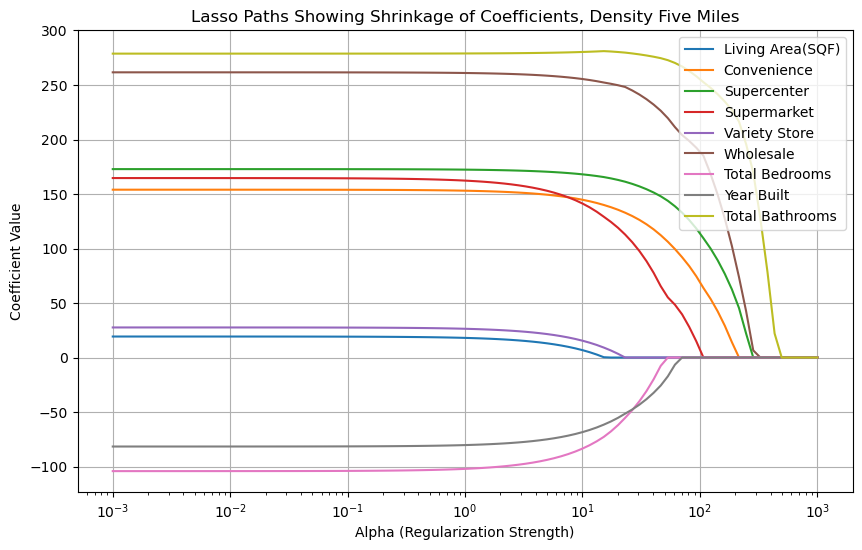

In [110]:
# Define the range of alpha values (regularization strength)
alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(transformed_df_five, y_five)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)', 'Convenience', 'Supercenter', 'Supermarket', 'Variety Store', 'Wholesale', 'Total Bedrooms', 'Year Built', 'Total Bathrooms']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients, Density Five Miles")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
plt.show()